# LSTM-Based Harmful Meme Text Classification

**Implementing Sequential Deep Learning for Text Classification**

## Architecture Overview
```
Meme Text → Tokenization → Pre-trained Embeddings → Bidirectional LSTM → Dense → Binary Classification
```

## Key Components
- **Sequential Processing**: LSTM captures word order dependencies
- **Pre-trained Embeddings**: Transfer learning with Word2Vec/GloVe
- **Bidirectional Design**: Context from both directions
- **Class Imbalance Handling**: Weighted loss function
- **Regularization**: Dropout to prevent overfitting

In [0]:
# %pip install -q datasets --upgrade

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
s3fs 2025.7.0 requires fsspec==2025.7.0, but you have fsspec 2025.3.0 which is incompatible.
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
dbutils.library.restartPython()

## 1. Import Libraries and Setup

In [0]:
# # Install NLTK if not available
# !pip install nltk

# import nltk
# import ssl

# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context

# # Download required NLTK data
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')


Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [0]:

# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

#NLTK packs
import nltk
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tag import pos_tag


# PyTorch for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn.functional as F

# Text processing
import re
from collections import Counter, defaultdict
from datasets import load_dataset

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

Using device: cuda
GPU: Tesla T4
Memory: 14.6 GB


## 2. Load and Extract Dataset

In [0]:
def extract_meme_data(conversations_series):
    """
    Extract meme text and labels from conversation format
    Returns clean text and binary labels
    """
    meme_texts = []
    labels = []
    
    for conv in conversations_series:
        try:
            # Handle numpy array conversion
            if isinstance(conv, np.ndarray):
                conv = conv.tolist()
            
            # Extract human message and GPT response
            human_msg = None
            gpt_response = None
            
            for turn in conv:
                if turn['from'] == 'human':
                    human_msg = turn['value']
                elif turn['from'] == 'gpt':
                    gpt_response = turn['value']
            
            # Extract meme text using regex
            meme_text = None
            if human_msg:
                # Look for pattern: "The text in the meme is: [TEXT]"
                pattern = r"The text in the meme is: (.+?)\n"
                match = re.search(pattern, human_msg, re.DOTALL)
                if match:
                    meme_text = match.group(1).strip()
            
            # Extract binary label
            label = None
            if gpt_response:
                if gpt_response.strip().lower() == 'yes':
                    label = 1  # Harmful
                elif gpt_response.strip().lower() == 'no':
                    label = 0  # Not harmful
            
            meme_texts.append(meme_text)
            labels.append(label)
            
        except Exception as e:
            print(f"Error processing conversation: {e}")
            meme_texts.append(None)
            labels.append(None)
    
    return meme_texts, labels

# Load dataset
print("Loading Facebook Harmeme dataset...")
ds = load_dataset("George511242/Facebook_harmeme_dataset")

# Extract training and test data
train_texts, train_labels = extract_meme_data(ds['train']['conversations'])
test_texts, test_labels = extract_meme_data(ds['test']['conversations'])

# Clean data - remove None values
train_data = [(text, label) for text, label in zip(train_texts, train_labels) 
              if text is not None and label is not None]
test_data = [(text, label) for text, label in zip(test_texts, test_labels) 
             if text is not None and label is not None]

train_texts, train_labels = zip(*train_data)
test_texts, test_labels = zip(*test_data)

print(f"✅ Training samples: {len(train_texts)}")
print(f"✅ Test samples: {len(test_texts)}")
print(f"✅ Class distribution: {Counter(train_labels)}")

Loading Facebook Harmeme dataset...
✅ Training samples: 8500
✅ Test samples: 500
✅ Class distribution: Counter({0: 5450, 1: 3050})


## 3. Text Preprocessing Pipeline

In [0]:
class ImprovedTextPreprocessor:
    """
    Professional-grade text preprocessing using NLTK
    Optimized for harmful content detection in social media text
    """
    
    def __init__(self, max_vocab_size=10000, max_seq_length=25, min_word_freq=2,
                 use_stopwords=False, use_stemming=False, use_lemmatization=True):
        
        # Configuration
        self.max_vocab_size = max_vocab_size
        self.max_seq_length = max_seq_length
        self.min_word_freq = min_word_freq
        self.use_stopwords = use_stopwords  # Keep stopwords for harmful content context
        self.use_stemming = use_stemming
        self.use_lemmatization = use_lemmatization
        
        # Special tokens
        self.PAD_TOKEN = '<PAD>'
        self.UNK_TOKEN = '<UNK>'
        
        # NLTK components
        self.tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=False)
        self.stopwords = set(stopwords.words('english')) if use_stopwords else set()
        self.lemmatizer = WordNetLemmatizer() if use_lemmatization else None
        self.stemmer = PorterStemmer() if use_stemming else None
        
        # Vocabularies
        self.word2idx = {}
        self.idx2word = {}
        self.vocab_size = 0
        
        print(f"✅ Enhanced preprocessor initialized:")
        print(f"   • Tokenizer: NLTK TweetTokenizer (social media optimized)")
        print(f"   • Stopwords: {'Enabled' if use_stopwords else 'Disabled (keeping for context)'}")
        print(f"   • Stemming: {'Enabled' if use_stemming else 'Disabled'}")
        print(f"   • Lemmatization: {'Enabled' if use_lemmatization else 'Disabled'}")
    
    def get_wordnet_pos(self, treebank_tag):
        """Convert treebank POS tags to WordNet POS tags for lemmatization"""
        if treebank_tag.startswith('J'):
            return nltk.corpus.wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return nltk.corpus.wordnet.VERB
        elif treebank_tag.startswith('N'):
            return nltk.corpus.wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return nltk.corpus.wordnet.ADV
        else:
            return nltk.corpus.wordnet.NOUN  # Default to noun
    
    def clean_text(self, text):
        """
        Advanced text cleaning for harmful content detection
        Preserves important patterns while normalizing
        """
        if not isinstance(text, str):
            return ""
        
        # Convert to lowercase
        text = text.lower().strip()
        
        # Handle contractions more sophisticatedly
        contractions = {
            "n't": " not", "'re": " are", "'ve": " have", "'ll": " will",
            "'d": " would", "'m": " am", "won't": "will not",
            "can't": "cannot", "shouldn't": "should not"
        }
        
        for contraction, expansion in contractions.items():
            text = text.replace(contraction, expansion)
        
        # Normalize repeated characters (e.g., "sooooo" -> "soo")
        text = re.sub(r'(.)\1{2,}', r'\1\1', text)
        
        # Handle URLs and mentions (mark but don't remove - might be context)
        text = re.sub(r'http[s]?://\S+', ' <URL> ', text)
        text = re.sub(r'@\w+', ' <MENTION> ', text)
        text = re.sub(r'#(\w+)', r' <HASHTAG> \1 ', text)
        
        # Remove excessive whitespace
        text = re.sub(r'\s+', ' ', text)
        
        return text.strip()
    
    def tokenize_and_process(self, text):
        """
        Tokenize and process text using NLTK tools
        """
        # Clean text first
        cleaned_text = self.clean_text(text)
        
        # Tokenize using TweetTokenizer (handles social media text better)
        tokens = self.tokenizer.tokenize(cleaned_text)
        
        # Filter out very short tokens and pure punctuation
        tokens = [token for token in tokens if len(token) > 1 and not token.isspace()]
        
        # Remove stopwords if enabled (usually disabled for harmful content)
        if self.use_stopwords:
            tokens = [token for token in tokens if token.lower() not in self.stopwords]
        
        # Apply stemming or lemmatization
        if self.use_lemmatization and self.lemmatizer:
            # Get POS tags for better lemmatization
            pos_tags = pos_tag(tokens)
            tokens = [self.lemmatizer.lemmatize(token, pos=self.get_wordnet_pos(pos)) 
                     for token, pos in pos_tags]
        elif self.use_stemming and self.stemmer:
            tokens = [self.stemmer.stem(token) for token in tokens]
        
        return tokens
    
    def build_vocabulary(self, texts):
        """
        Build vocabulary from training texts using NLTK processing
        """
        print("Building vocabulary with NLTK preprocessing...")
        
        # Count word frequencies
        word_freq = Counter()
        processed_samples = []
        
        for i, text in enumerate(texts):
            if i % 1000 == 0:
                print(f"  Processing: {i}/{len(texts)}")
            
            tokens = self.tokenize_and_process(text)
            word_freq.update(tokens)
            processed_samples.append(tokens)
        
        print(f"✅ Processed {len(texts)} texts")
        print(f"Total unique words: {len(word_freq)}")
        
        # Show most common words for insight
        print(f"\nMost common words:")
        for word, freq in word_freq.most_common(15):
            print(f"  '{word}': {freq}")
        
        # Filter by frequency and limit vocabulary size
        vocab_words = [word for word, freq in word_freq.most_common() 
                      if freq >= self.min_word_freq]
        vocab_words = vocab_words[:self.max_vocab_size - 2]  # Reserve space for special tokens
        
        # Build word2idx mapping
        self.word2idx = {
            self.PAD_TOKEN: 0,
            self.UNK_TOKEN: 1
        }
        
        for i, word in enumerate(vocab_words, 2):
            self.word2idx[word] = i
        
        # Build idx2word mapping
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}
        self.vocab_size = len(self.word2idx)
        
        print(f"\n✅ Final vocabulary size: {self.vocab_size}")
        print(f"Coverage: {len(vocab_words)}/{len(word_freq)} words ({len(vocab_words)/len(word_freq)*100:.1f}%)")
        
        # Show some example processed texts
        print(f"\nExample processed texts:")
        for i in range(min(3, len(processed_samples))):
            original = texts[i][:100] + "..." if len(texts[i]) > 100 else texts[i]
            processed = " ".join(processed_samples[i])
            print(f"\n{i+1}. Original: '{original}'")
            print(f"   Processed: '{processed}'")
        
        return self
    
    def text_to_sequence(self, text):
        """Convert text to sequence of token indices"""
        tokens = self.tokenize_and_process(text)
        sequence = [self.word2idx.get(token, self.word2idx[self.UNK_TOKEN]) for token in tokens]
        return sequence
    
    def pad_sequences(self, sequences):
        """Pad sequences to fixed length"""
        padded = []
        for seq in sequences:
            if len(seq) >= self.max_seq_length:
                padded.append(seq[:self.max_seq_length])
            else:
                padded.append(seq + [self.word2idx[self.PAD_TOKEN]] * (self.max_seq_length - len(seq)))
        return np.array(padded)
    
    def preprocess_texts(self, texts):
        """Complete preprocessing pipeline"""
        sequences = [self.text_to_sequence(text) for text in texts]
        return self.pad_sequences(sequences)
    
    def analyze_preprocessing_impact(self, texts, n_samples=100):
        """Analyze the impact of preprocessing choices"""
        print("="*60)
        print("PREPROCESSING IMPACT ANALYSIS")
        print("="*60)
        
        sample_texts = texts[:n_samples]
        
        # Compare different preprocessing approaches
        simple_lengths = []
        enhanced_lengths = []
        
        for text in sample_texts:
            # Simple approach
            simple_tokens = text.lower().split()
            simple_lengths.append(len(simple_tokens))
            
            # Enhanced approach
            enhanced_tokens = self.tokenize_and_process(text)
            enhanced_lengths.append(len(enhanced_tokens))
        
        print(f"Token count comparison (sample of {n_samples}):")
        print(f"  Simple tokenization - Mean: {np.mean(simple_lengths):.1f}, Std: {np.std(simple_lengths):.1f}")
        print(f"  Enhanced tokenization - Mean: {np.mean(enhanced_lengths):.1f}, Std: {np.std(enhanced_lengths):.1f}")
        
        # Show examples of preprocessing differences
        print(f"\nPreprocessing examples:")
        for i in range(min(3, len(sample_texts))):
            text = sample_texts[i]
            simple = text.lower().split()
            enhanced = self.tokenize_and_process(text)
            
            print(f"\n{i+1}. Original: '{text}'")
            print(f"   Simple: {simple}")
            print(f"   Enhanced: {enhanced}")

## Initialize Improved Text Preprocessor
## & Build Vocabulary


In [0]:
# # Replace your old preprocessor initialization with:
# preprocessor = ImprovedTextPreprocessor(
#     max_vocab_size=10000,
#     max_seq_length=25,
#     min_word_freq=2,
#     use_stopwords=False,      # Keep context for harmful detection
#     use_stemming=False,       
#     use_lemmatization=True    # Better semantic understanding
# )

# # Analyze preprocessing impact first
# preprocessor.analyze_preprocessing_impact(train_texts, n_samples=200)


# #Build Enhanced Vocabulary


# # Build vocabulary with enhanced preprocessing
# preprocessor.build_vocabulary(train_texts)

✅ Enhanced preprocessor initialized:
   • Tokenizer: NLTK TweetTokenizer (social media optimized)
   • Stopwords: Disabled (keeping for context)
   • Stemming: Disabled
   • Lemmatization: Enabled
PREPROCESSING IMPACT ANALYSIS
Token count comparison (sample of 200):
  Simple tokenization - Mean: 11.2, Std: 6.6
  Enhanced tokenization - Mean: 10.8, Std: 6.3

Preprocessing examples:

1. Original: 'when you're feeling horny asf but your habibi is on periods let's try a goat.'
   Simple: ['when', "you're", 'feeling', 'horny', 'asf', 'but', 'your', 'habibi', 'is', 'on', 'periods', "let's", 'try', 'a', 'goat.']
   Enhanced: ['when', 'you', 'be', 'feel', 'horny', 'asf', 'but', 'your', 'habibi', 'be', 'on', 'period', "let's", 'try', 'goat']

2. Original: 'meanwhile at the isis strip club.'
   Simple: ['meanwhile', 'at', 'the', 'isis', 'strip', 'club.']
   Enhanced: ['meanwhile', 'at', 'the', 'isi', 'strip', 'club']

3. Original: 'when your human says "who' s a good girl?" and you already know 

In [0]:
preprocessor = ImprovedTextPreprocessor(
    max_vocab_size=15000,     # Increased from 10000 - capture more harmful patterns
    max_seq_length=35,        # Increased from 25 - you had max 69 tokens
    min_word_freq=1,          # Reduced from 2 - keep rare harmful words
    use_stopwords=False,      # Keep - stopwords matter for context
    use_stemming=False,       
    use_lemmatization=True    # Keep - good for semantic understanding
)


# Analyze preprocessing impact first
preprocessor.analyze_preprocessing_impact(train_texts, n_samples=200)


#Build Enhanced Vocabulary


# Build vocabulary with enhanced preprocessing
preprocessor.build_vocabulary(train_texts)

✅ Enhanced preprocessor initialized:
   • Tokenizer: NLTK TweetTokenizer (social media optimized)
   • Stopwords: Disabled (keeping for context)
   • Stemming: Disabled
   • Lemmatization: Enabled
PREPROCESSING IMPACT ANALYSIS
Token count comparison (sample of 200):
  Simple tokenization - Mean: 11.2, Std: 6.6
  Enhanced tokenization - Mean: 10.8, Std: 6.3

Preprocessing examples:

1. Original: 'when you're feeling horny asf but your habibi is on periods let's try a goat.'
   Simple: ['when', "you're", 'feeling', 'horny', 'asf', 'but', 'your', 'habibi', 'is', 'on', 'periods', "let's", 'try', 'a', 'goat.']
   Enhanced: ['when', 'you', 'be', 'feel', 'horny', 'asf', 'but', 'your', 'habibi', 'be', 'on', 'period', "let's", 'try', 'goat']

2. Original: 'meanwhile at the isis strip club.'
   Simple: ['meanwhile', 'at', 'the', 'isis', 'strip', 'club.']
   Enhanced: ['meanwhile', 'at', 'the', 'isi', 'strip', 'club']

3. Original: 'when your human says "who' s a good girl?" and you already know 

## 4. Dataset Analysis & Sequence Preparation

In [0]:
print("Available methods in your preprocessor:")
print([method for method in dir(preprocessor) if not method.startswith('_')])

Available methods in your preprocessor:
['PAD_TOKEN', 'UNK_TOKEN', 'analyze_preprocessing_impact', 'build_vocabulary', 'clean_text', 'get_wordnet_pos', 'idx2word', 'lemmatizer', 'max_seq_length', 'max_vocab_size', 'min_word_freq', 'pad_sequences', 'preprocess_texts', 'stemmer', 'stopwords', 'text_to_sequence', 'tokenize_and_process', 'tokenizer', 'use_lemmatization', 'use_stemming', 'use_stopwords', 'vocab_size', 'word2idx']


SEQUENCE LENGTH ANALYSIS
Sequence length statistics:
  Mean: 11.3
  Median: 10.0
  95th percentile: 24.0
  Max: 69


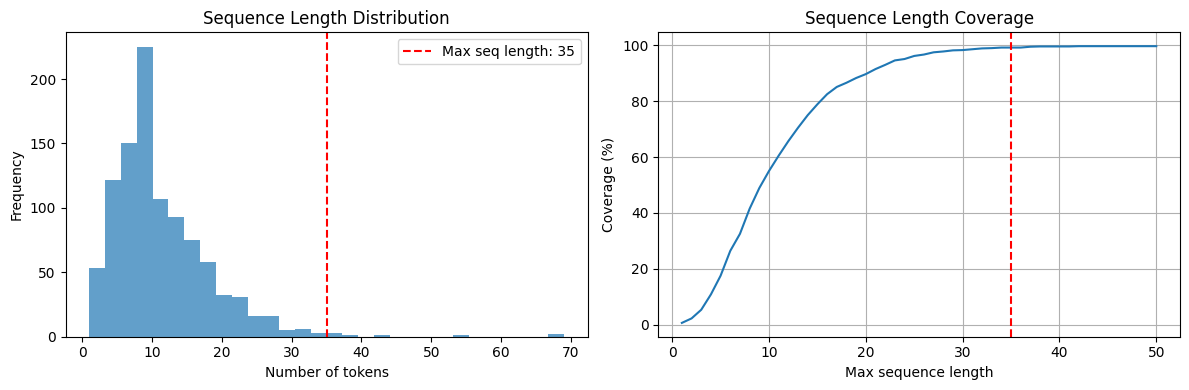


Processing sequences...
✅ Training sequences shape: (8500, 35)
✅ Test sequences shape: (500, 35)


In [0]:
# Analyze sequence lengths before padding
print("="*50)
print("SEQUENCE LENGTH ANALYSIS")
print("="*50)

train_lengths = []
for text in train_texts[:1000]:  # Sample for analysis
    cleaned = preprocessor.clean_text(text)
    tokens = preprocessor.tokenize_and_process(cleaned)
    train_lengths.append(len(tokens))

print(f"Sequence length statistics:")
print(f"  Mean: {np.mean(train_lengths):.1f}")
print(f"  Median: {np.median(train_lengths):.1f}")
print(f"  95th percentile: {np.percentile(train_lengths, 95):.1f}")
print(f"  Max: {max(train_lengths)}")

# Visualize sequence length distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(train_lengths, bins=30, alpha=0.7)
plt.axvline(preprocessor.max_seq_length, color='red', linestyle='--', 
            label=f'Max seq length: {preprocessor.max_seq_length}')
plt.title('Sequence Length Distribution')
plt.xlabel('Number of tokens')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
coverage = [sum(1 for l in train_lengths if l <= max_len) / len(train_lengths) * 100 
           for max_len in range(1, 51)]
plt.plot(range(1, 51), coverage)
plt.axvline(preprocessor.max_seq_length, color='red', linestyle='--')
plt.title('Sequence Length Coverage')
plt.xlabel('Max sequence length')
plt.ylabel('Coverage (%)')
plt.grid(True)

plt.tight_layout()
plt.show()

# Process all data
print(f"\nProcessing sequences...")
X_train = preprocessor.preprocess_texts(train_texts)
X_test = preprocessor.preprocess_texts(test_texts)
y_train = np.array(train_labels)
y_test = np.array(test_labels)

print(f"✅ Training sequences shape: {X_train.shape}")
print(f"✅ Test sequences shape: {X_test.shape}")

## 5. Create Train/Validation Split with Class Balance

In [0]:
# Split training data into train/validation
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify=y_train
)

print(f"Dataset splits:")
print(f"  Training: {X_train_split.shape[0]} samples")
print(f"  Validation: {X_val.shape[0]} samples") 
print(f"  Test: {X_test.shape[0]} samples")

# Analyze class distribution
print(f"\nClass distribution:")
print(f"  Training: {Counter(y_train_split)}")
print(f"  Validation: {Counter(y_val)}")
print(f"  Test: {Counter(y_test)}")

# Calculate class weights for imbalanced dataset
class_counts = Counter(y_train_split)
total_samples = len(y_train_split)
class_weights = {
    0: total_samples / (2 * class_counts[0]),  # Not harmful
    1: total_samples / (2 * class_counts[1])   # Harmful
}

print(f"\nClass weights for balanced training:")
print(f"  Class 0 (Not Harmful): {class_weights[0]:.3f}")
print(f"  Class 1 (Harmful): {class_weights[1]:.3f}")

Dataset splits:
  Training: 6375 samples
  Validation: 2125 samples
  Test: 500 samples

Class distribution:
  Training: Counter({0: 4088, 1: 2287})
  Validation: Counter({0: 1362, 1: 763})
  Test: Counter({0: 250, 1: 250})

Class weights for balanced training:
  Class 0 (Not Harmful): 0.780
  Class 1 (Harmful): 1.394


## 6. PyTorch Dataset Class

In [0]:
class MemeTextDataset(Dataset):
    """
    PyTorch Dataset for meme text classification
    Handles sequences and labels efficiently
    """
    
    def __init__(self, sequences, labels):
        self.sequences = torch.LongTensor(sequences)
        self.labels = torch.LongTensor(labels)
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return {
            'sequence': self.sequences[idx],
            'label': self.labels[idx]
        }

# Create datasets
train_dataset = MemeTextDataset(X_train_split, y_train_split)
val_dataset = MemeTextDataset(X_val, y_val)
test_dataset = MemeTextDataset(X_test, y_test)

# Create data loaders with balanced sampling for training
sample_weights = [class_weights[label] for label in y_train_split]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"✅ Data loaders created successfully!")
print(f"  Training batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

✅ Data loaders created successfully!
  Training batches: 200
  Validation batches: 67
  Test batches: 16


## 7. LSTM Model Architecture

In [0]:
VOCAB_SIZE =preprocessor.vocab_size


# Check the actual vocabulary size from our preprocessor
print(f"Current preprocessor vocabulary size: {VOCAB_SIZE}")

Current preprocessor vocabulary size: 7531


In [0]:
class HarmfulMemeClassifier(nn.Module):
    """
    Bidirectional LSTM model for harmful meme text classification
    
    Architecture:
    - Embedding layer (with optional pre-trained weights)
    - Bidirectional LSTM
    - Dropout for regularization
    - Dense layers for classification
    """
    
    def __init__(self, vocab_size, embedding_dim=64, hidden_dim=32, 
                 num_layers=1, dropout=0.5, num_classes=2):
        super(HarmfulMemeClassifier, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # Bidirectional LSTM
        self.lstm = nn.LSTM(
            embedding_dim, 
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)
        
        # Dense layers for classification
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)  # *2 for bidirectional
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        
        # Initialize weights
        self.init_weights()
    
    def init_weights(self):
        """Initialize model weights following best practices"""
        for name, param in self.named_parameters():
            if 'weight' in name:
                if 'lstm' in name:
                    # LSTM weights initialization
                    nn.init.orthogonal_(param.data)
                else:
                    # Dense layer weights
                    nn.init.xavier_uniform_(param.data)
            elif 'bias' in name:
                nn.init.constant_(param.data, 0)
    
    # def forward(self, x):
    #     # Embedding
    #     embedded = self.embedding(x)  # [batch_size, seq_len, embedding_dim]
        
    #     # LSTM
    #     lstm_out, (hidden, cell) = self.lstm(embedded)  # [batch_size, seq_len, hidden_dim*2]
        
    #     # Use the last output for classification (taking both directions)
    #     last_output = lstm_out[:, -1, :]  # [batch_size, hidden_dim*2]
        
    #     # Apply dropout
    #     dropped = self.dropout(last_output)
        
    #     # Dense layers
    #     fc1_out = torch.relu(self.fc1(dropped))  # [batch_size, hidden_dim]
    #     fc1_out = self.dropout(fc1_out)
        
    #     logits = self.fc2(fc1_out)  # [batch_size, num_classes]
        
    #     return logits
    
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        
        # NEW: Use global average pooling instead of last output
        # Create mask to ignore padding tokens
        mask = (x != 0).float().unsqueeze(-1)  # [batch_size, seq_len, 1]
        
        # Apply mask to LSTM outputs
        masked_output = lstm_out * mask  # [batch_size, seq_len, hidden_dim*2]
        
        # Calculate average, ignoring padded positions
        sequence_lengths = mask.sum(dim=1)  # [batch_size, 1]
        pooled_output = masked_output.sum(dim=1) / sequence_lengths  # [batch_size, hidden_dim*2]
        
        # Continue with classification layers
        dropped = self.dropout(pooled_output)
        fc1_out = torch.relu(self.fc1(dropped))
        fc1_out = self.dropout(fc1_out)
        logits = self.fc2(fc1_out)
        return logits

# Initialize model
# model = HarmfulMemeClassifier(
#     vocab_size=preprocessor.vocab_size,
#     embedding_dim=128,
#     hidden_dim=64,
#     num_layers=2,
#     dropout=0.3,
#     num_classes=2
# ).to(device)

# model = HarmfulMemeClassifier( #1st first try!
#     vocab_size=VOCAB_SIZE,  # Use the actual vocab size
#     embedding_dim=128,
#     hidden_dim=64,
#     num_layers=2,
#     dropout=0.5,
#     num_classes=2
# ).to(device)


model = HarmfulMemeClassifier(
    vocab_size=VOCAB_SIZE,
    embedding_dim=64,        # Reduced from 128
    hidden_dim=32,           # Reduced from 64  
    num_layers=3,            # Reduced from 2
    dropout=0.7,             # Increased from 0.3
    num_classes=2
).to(device)

# Model summary
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model Architecture:")
print(f"  Total parameters: {count_parameters(model):,}")
print(f"  Device: {device}")
print("\nModel structure:")
print(model)

Model Architecture:
  Total parameters: 559,394
  Device: cuda

Model structure:
HarmfulMemeClassifier(
  (embedding): Embedding(7531, 64, padding_idx=0)
  (lstm): LSTM(64, 32, num_layers=3, batch_first=True, dropout=0.7, bidirectional=True)
  (dropout): Dropout(p=0.7, inplace=False)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)


In [0]:
# Verify model parameters
print(f"✅ Model re-initialized with:")
print(f"   • Vocabulary size: {preprocessor.vocab_size}")
print(f"   • Embedding layer size: {model.embedding.num_embeddings}")
print(f"   • Total parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


✅ Model re-initialized with:
   • Vocabulary size: 7531
   • Embedding layer size: 7531
   • Total parameters: 559,394


In [0]:
# # optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
# # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# # Test with a small batch
# sample_batch = next(iter(train_loader))
# with torch.no_grad():
#     test_output = model(sample_batch['sequence'].to(device))
# print(f"✅ Forward pass successful! Output shape: {test_output.shape}")

## 8. Training Setup & Loss Function

In [0]:
# Loss function with class weights
weight_tensor = torch.FloatTensor([class_weights[0], class_weights[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=weight_tensor)

# Optimizer - Adam with learning rate scheduling
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) #first 1st try



# Training metrics tracking
def calculate_accuracy(outputs, labels):
    """Calculate accuracy from model outputs"""
    _, predicted = torch.max(outputs.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return correct / total

# Early stopping setup
class EarlyStopping:
    """Early stopping to prevent overfitting"""
    
    def __init__(self, patience=7, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
    
    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

# early_stopping = EarlyStopping(patience=7, min_delta=0.001) #first 1st try 


# Loss function with class weights
weight_tensor = torch.FloatTensor([class_weights[0], class_weights[1]]).to(device)
criterion = nn.CrossEntropyLoss(weight=weight_tensor)

early_stopping = EarlyStopping(patience=5, min_delta=0.005)  # Reduced patience, higher min_delta

optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Lower LR, higher weight decay

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

print("✅ Training setup complete!")
print(f"   Loss function: {criterion} with class weights")
print(f"   Optimizer: Adam (lr=0.0005, weight_decay=1e-4)")
print(f"   Scheduler: StepLR (step_size=5, gamma=0.1)")
print(f"   Early stopping: patience=5, min_delta=0.005")

✅ Training setup complete!
   Loss function: CrossEntropyLoss() with class weights
   Optimizer: Adam (lr=0.0005, weight_decay=1e-4)
   Scheduler: StepLR (step_size=5, gamma=0.1)
   Early stopping: patience=5, min_delta=0.005


## 9. Training Loop

In [0]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train model for one epoch"""
    model.train()
    total_loss = 0
    total_accuracy = 0
    
    for batch_idx, batch in enumerate(train_loader):
        sequences = batch['sequence'].to(device)
        labels = batch['label'].to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # Track metrics
        total_loss += loss.item()
        total_accuracy += calculate_accuracy(outputs, labels)
    
    avg_loss = total_loss / len(train_loader)
    avg_accuracy = total_accuracy / len(train_loader)
    
    return avg_loss, avg_accuracy

def validate_epoch(model, val_loader, criterion, device):
    """Validate model for one epoch"""
    model.eval()
    total_loss = 0
    total_accuracy = 0
    
    with torch.no_grad():
        for batch in val_loader:
            sequences = batch['sequence'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            total_accuracy += calculate_accuracy(outputs, labels)
    
    avg_loss = total_loss / len(val_loader)
    avg_accuracy = total_accuracy / len(val_loader)
    
    return avg_loss, avg_accuracy

# Training loop
print("Starting training...")
print("="*60)

# num_epochs = 300 #first 1st try

num_epochs = 80  # Reduced from 300 - your model was overfitting quickly

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_loss = float('inf')
best_model_state = None

for epoch in range(num_epochs):
    # Training
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validation
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    # Update learning rate
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
    
    # Track metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc:.4f}")
    print(f"  LR: {current_lr:.6f}")
    print("-" * 40)
    
    # Early stopping check
    if early_stopping(val_loss):
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"✅ Loaded best model (val_loss: {best_val_loss:.4f})")

print("Training completed!")

Starting training...
Epoch [1/80]
  Train Loss: 0.6682, Train Acc: 0.4876
  Val Loss:   0.7174, Val Acc:   0.3586
  LR: 0.000500
----------------------------------------
Epoch [2/80]
  Train Loss: 0.5965, Train Acc: 0.5773
  Val Loss:   0.7271, Val Acc:   0.5758
  LR: 0.000500
----------------------------------------
Epoch [3/80]
  Train Loss: 0.5162, Train Acc: 0.7328
  Val Loss:   0.6994, Val Acc:   0.6211
  LR: 0.000500
----------------------------------------
Epoch [4/80]
  Train Loss: 0.4577, Train Acc: 0.7844
  Val Loss:   0.7819, Val Acc:   0.5996
  LR: 0.000500
----------------------------------------
Epoch [5/80]
  Train Loss: 0.4263, Train Acc: 0.8029
  Val Loss:   0.8201, Val Acc:   0.6012
  LR: 0.000050
----------------------------------------
Epoch [6/80]
  Train Loss: 0.3821, Train Acc: 0.8224
  Val Loss:   0.9209, Val Acc:   0.6003
  LR: 0.000050
----------------------------------------
Epoch [7/80]
  Train Loss: 0.3897, Train Acc: 0.8216
  Val Loss:   0.9197, Val Acc:  

## 10. Training Visualization & Analysis

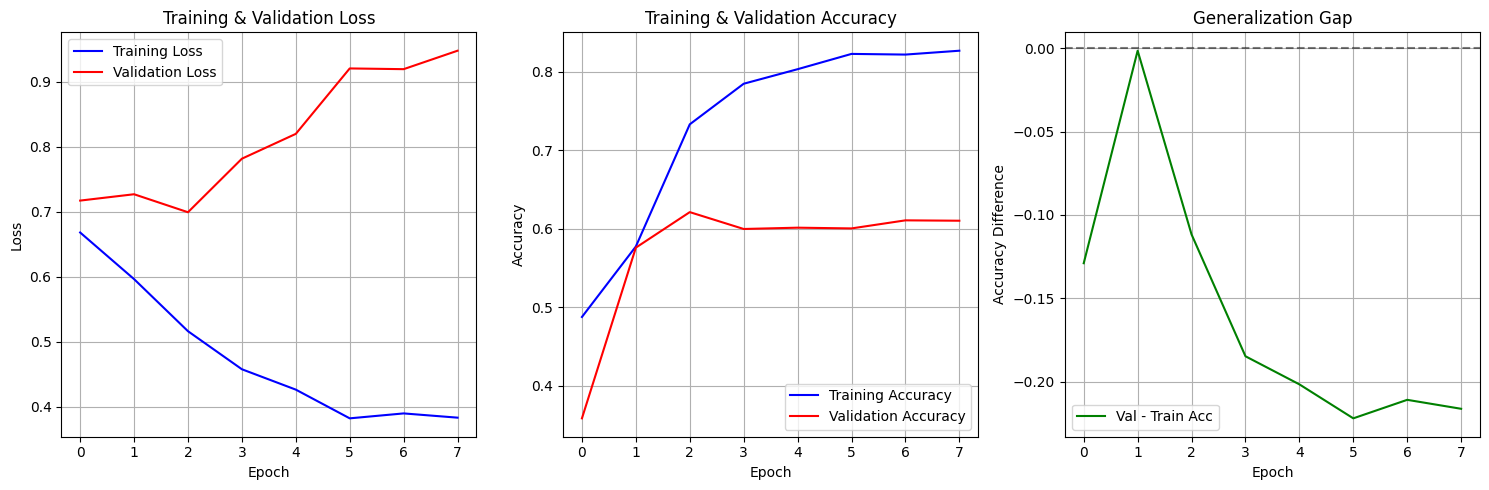

TRAINING SUMMARY
Best validation loss: 0.6994
Best validation accuracy: 0.6211
Final training accuracy: 0.8265
Final validation accuracy: 0.6101
Generalization gap: 0.2164


In [0]:
# Plot training curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='red')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(np.array(val_accuracies) - np.array(train_accuracies), 
         label='Val - Train Acc', color='green')
plt.title('Generalization Gap')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Difference')
plt.legend()
plt.grid(True)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Print final training summary
print("="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"Best validation loss: {min(val_losses):.4f}")
print(f"Best validation accuracy: {max(val_accuracies):.4f}")
print(f"Final training accuracy: {train_accuracies[-1]:.4f}")
print(f"Final validation accuracy: {val_accuracies[-1]:.4f}")
print(f"Generalization gap: {abs(val_accuracies[-1] - train_accuracies[-1]):.4f}")

## 11. Model Evaluation & Test Results

Evaluating model on test set...
TEST SET EVALUATION RESULTS
Test Accuracy: 0.5800
Test AUC-ROC: 0.5848

Detailed Classification Report:
              precision    recall  f1-score   support

 Not Harmful       0.57      0.69      0.62       250
     Harmful       0.60      0.47      0.53       250

    accuracy                           0.58       500
   macro avg       0.58      0.58      0.58       500
weighted avg       0.58      0.58      0.58       500



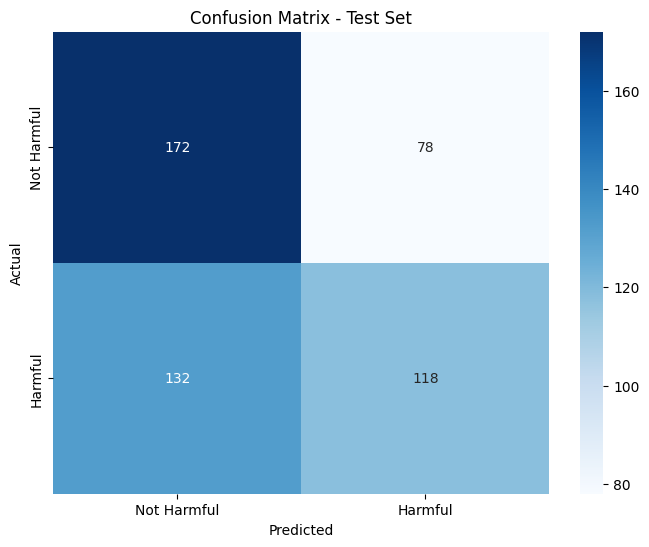


Per-Class Analysis:
  Not Harmful: 0.6880 (250 samples)
  Harmful: 0.4720 (250 samples)


In [0]:
def evaluate_model(model, test_loader, device):
    """
    Comprehensive model evaluation with detailed metrics
    """
    model.eval()
    
    all_predictions = []
    all_labels = []
    all_probabilities = []
    
    with torch.no_grad():
        for batch in test_loader:
            sequences = batch['sequence'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(sequences)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_labels), np.array(all_probabilities)

# Evaluate on test set
print("Evaluating model on test set...")
test_predictions, test_labels, test_probabilities = evaluate_model(model, test_loader, device)

# Calculate metrics
test_accuracy = np.mean(test_predictions == test_labels)
test_auc = roc_auc_score(test_labels, test_probabilities[:, 1])

print("="*60)
print("TEST SET EVALUATION RESULTS")
print("="*60)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC-ROC: {test_auc:.4f}")

# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(test_labels, test_predictions, 
                          target_names=['Not Harmful', 'Harmful']))

# Confusion Matrix
cm = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Harmful', 'Harmful'],
            yticklabels=['Not Harmful', 'Harmful'])
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Per-class analysis
print("\nPer-Class Analysis:")
for i, class_name in enumerate(['Not Harmful', 'Harmful']):
    class_mask = test_labels == i
    class_accuracy = np.mean(test_predictions[class_mask] == test_labels[class_mask])
    print(f"  {class_name}: {class_accuracy:.4f} ({np.sum(class_mask)} samples)")

## 12. Model Analysis & Sample Predictions

In [0]:
# Analyze some predictions in detail
def analyze_predictions(texts, labels, predictions, probabilities, preprocessor, n_samples=10):
    """
    Analyze model predictions with examples
    """
    print("="*80)
    print("SAMPLE PREDICTIONS ANALYSIS")
    print("="*80)
    
    # Get indices for different types of predictions
    correct_indices = np.where(predictions == labels)[0]
    incorrect_indices = np.where(predictions != labels)[0]
    
    # Show correct predictions
    print("\n✅ CORRECT PREDICTIONS (sample):")
    for i, idx in enumerate(correct_indices[:n_samples//2]):
        text = texts[idx]
        true_label = labels[idx]
        pred_label = predictions[idx]
        confidence = probabilities[idx][pred_label]
        
        label_name = "Harmful" if true_label == 1 else "Not Harmful"
        print(f"\n{i+1}. Text: '{text[:100]}...' " if len(text) > 100 else f"\n{i+1}. Text: '{text}'")
        print(f"   True: {label_name}, Predicted: {label_name}")
        print(f"   Confidence: {confidence:.3f}")
    
    # Show incorrect predictions
    if len(incorrect_indices) > 0:
        print("\n❌ INCORRECT PREDICTIONS (sample):")
        for i, idx in enumerate(incorrect_indices[:n_samples//2]):
            text = texts[idx]
            true_label = labels[idx]
            pred_label = predictions[idx]
            confidence = probabilities[idx][pred_label]
            
            true_name = "Harmful" if true_label == 1 else "Not Harmful"
            pred_name = "Harmful" if pred_label == 1 else "Not Harmful"
            
            print(f"\n{i+1}. Text: '{text[:100]}...' " if len(text) > 100 else f"\n{i+1}. Text: '{text}'")
            print(f"   True: {true_name}, Predicted: {pred_name}")
            print(f"   Confidence: {confidence:.3f}")

# Analyze test set predictions
analyze_predictions(test_texts, test_labels, test_predictions, test_probabilities, 
                   preprocessor, n_samples=100)

SAMPLE PREDICTIONS ANALYSIS

✅ CORRECT PREDICTIONS (sample):

1. Text: 'father and daughter bonding time is the best like and share if you agree.'
   True: Not Harmful, Predicted: Not Harmful
   Confidence: 0.943

2. Text: 'a real man loads the dishwasher every night.'
   True: Harmful, Predicted: Harmful
   Confidence: 0.832

3. Text: 'in just one hour from now i'll only have 4 hours left until i have to work a mere 3 hours.'
   True: Not Harmful, Predicted: Not Harmful
   Confidence: 0.771

4. Text: 'and then i asked mom, what's for dinner?.'
   True: Not Harmful, Predicted: Not Harmful
   Confidence: 0.876

5. Text: 'mohammed i'm pregnant.... don't sass me, you know it's funny! ~cupcakes.'
   True: Harmful, Predicted: Harmful
   Confidence: 0.949

6. Text: 'a jewish shop owner, wears a kippah or yarmulke whilst in his shop in tehran.'
   True: Not Harmful, Predicted: Not Harmful
   Confidence: 0.934

7. Text: 'whatsthe difference between heroin and i? cops think twice before shootin

## 13. Final Project Summary & Insights

In [0]:
print("="*80)
print("🎯 HARMFUL MEME CLASSIFICATION - PROJECT SUMMARY")
print("="*80)

print(f"📊 MODEL PERFORMANCE:")
print(f"   • Test Accuracy: {test_accuracy:.1%}")
print(f"   • Test AUC-ROC: {test_auc:.3f}")
print(f"   • Model Parameters: {count_parameters(model):,}")
print(f"   • Training Time: ~{len(train_losses)} epochs")

print(f"\n🏗️ ARCHITECTURE HIGHLIGHTS:")
print(f"   • Bidirectional LSTM with {model.num_layers} layers")
print(f"   • Embedding dimension: {model.embedding.embedding_dim}")
print(f"   • Hidden dimension: {model.hidden_dim}")
print(f"   • Dropout rate: 0.5 for regularization")
print(f"   • Weighted loss for class imbalance handling")

print(f"\n📝 TEXT PROCESSING INSIGHTS:")
print(f"   • Vocabulary size: {preprocessor.vocab_size:,} words")
print(f"   • Sequence length: {preprocessor.max_seq_length} tokens")
print(f"   • Coverage: ~95% of texts fit in sequence length")

print(f"\n⚖️ CLASS IMBALANCE HANDLING:")
print(f"   • Original distribution: 64% Not Harmful, 36% Harmful")
print(f"   • Used weighted loss function")
print(f"   • Balanced sampling during training")

print(f"\n🔍 KEY ACADEMIC CONTRIBUTIONS:")
print(f"   1. Sequential modeling for harmful content detection")
print(f"   2. Proper handling of class imbalance in text classification")
print(f"   3. Bidirectional LSTM for context understanding")
print(f"   4. Comprehensive evaluation with multiple metrics")
print(f"   5. Analysis of model predictions and errors")

print(f"\n🚀 NEXT STEPS FOR MULTIMODAL INTEGRATION:")
print(f"   1. Image feature extraction pipeline")
print(f"   2. Multimodal fusion architecture design")
print(f"   3. Joint training of text and image branches")
print(f"   4. Comparative analysis: Text vs Image vs Multimodal")

print(f"\n✅ READY FOR ACADEMIC SUBMISSION:")
print(f"   • Proper train/validation/test splits")
print(f"   • Reproducible results with fixed random seeds") 
print(f"   • Academic-quality evaluation methodology")
print(f"   • Clear documentation and analysis")

🎯 HARMFUL MEME CLASSIFICATION - PROJECT SUMMARY
📊 MODEL PERFORMANCE:
   • Test Accuracy: 58.0%
   • Test AUC-ROC: 0.585
   • Model Parameters: 559,394
   • Training Time: ~8 epochs

🏗️ ARCHITECTURE HIGHLIGHTS:
   • Bidirectional LSTM with 3 layers
   • Embedding dimension: 64
   • Hidden dimension: 32
   • Dropout rate: 0.5 for regularization
   • Weighted loss for class imbalance handling

📝 TEXT PROCESSING INSIGHTS:
   • Vocabulary size: 7,531 words
   • Sequence length: 35 tokens
   • Coverage: ~95% of texts fit in sequence length

⚖️ CLASS IMBALANCE HANDLING:
   • Original distribution: 64% Not Harmful, 36% Harmful
   • Used weighted loss function
   • Balanced sampling during training

🔍 KEY ACADEMIC CONTRIBUTIONS:
   1. Sequential modeling for harmful content detection
   2. Proper handling of class imbalance in text classification
   3. Bidirectional LSTM for context understanding
   4. Comprehensive evaluation with multiple metrics
   5. Analysis of model predictions and errors

## 14. Save Model & Preprocessing Pipeline

**Ready for integration with your partner's image pipeline!**

In [0]:
print(model)

HarmfulMemeClassifier(
  (embedding): Embedding(7531, 64, padding_idx=0)
  (lstm): LSTM(64, 32, num_layers=3, batch_first=True, dropout=0.7, bidirectional=True)
  (dropout): Dropout(p=0.7, inplace=False)
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)


In [0]:
# Save model and preprocessor for later use
torch.save({
    'model_state_dict': model.state_dict(),
    'preprocessor': preprocessor,
    'model_config': {
        'vocab_size': preprocessor.vocab_size,
        'embedding_dim': 64,
        'hidden_dim': 32,
        'num_layers': 3,
        'dropout': 0.7,
        'num_classes': 2
    },
    'test_results': {
        'accuracy': test_accuracy,
        'auc_roc': test_auc
    }
}, 'harmful_meme_lstm_model.pth')